<a href="https://colab.research.google.com/github/slcnvly/A2C-Cartpole/blob/master/Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.0003
gamma = 0.98

In [2]:
def plot_learning_curve(scores):
    plt.figure(figsize=(10, 5))

    # 원본 점수 (연한 색으로 배경에 깔기)
    plt.plot(scores, label='Raw Score', color='cyan', alpha=0.3)

    # 이동 평균 (Moving Average) - 추세를 보기 위함
    # 최근 50개 에피소드의 평균을 계산해서 부드러운 선으로 그림
    window_size = 50
    moving_avg = []
    for i in range(len(scores)):
        start_idx = max(0, i - window_size)
        avg = sum(scores[start_idx : i+1]) / (i - start_idx + 1)
        moving_avg.append(avg)

    plt.plot(moving_avg, label=f'Moving Avg ({window_size})', color='blue')

    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('A2C Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        # 공통으로 쓸 몸통 (Feature Extractor)
        self.fc1 = nn.Linear(4, 256)
        # Head 1 (Actor): 행동 확률을 뱉음 (입력 256 -> 출력 2)
        self.fc_actor = nn.Linear(256, 2)
        # Head 2 (Critic): 상태 가치(V)를 뱉음 (입력 256 -> 출력 1, 스칼라)
        self.fc_critic = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # Actor는 확률, Softmax 필요
        prob = F.softmax(self.fc_actor(x), dim=1)
        # Critic은 그냥 점수, 활성화 함수 없이 Linear
        val = self.fc_critic(x)

        return prob, val

In [4]:
class A2CAgent(nn.Module):
    def __init__(self):
        super(A2CAgent, self).__init__()
        self.model = ActorCritic()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def train_net(self, s, a, r, s_prime, done):
        # A2C는 데이터가 쌓일 때까지 기다리지 x
        # 텐서 변환
        # 이때 gym 환경에서 s, _ = env.reset()이나 s_prime, ... = env.step(a)을 호출하면, 반환되는 s는 이미 Numpy Array 형태임
        # 또한 REINFORCE는 data에 리스트 형태로 쌓아두어 numpy array 형태로 변환하는게 효율적이였지만 A2C는 바로바로 쓰기 때문에 굳이 변환X
        s = torch.from_numpy(s).float().unsqueeze(0)
        s_prime = torch.from_numpy(s_prime).float().unsqueeze(0)
        # r(보상)도 텐서로 만들어줘야 계산 가능 (모양: [1, 1])
        r = torch.tensor([r]).float().unsqueeze(0)

        # 현재 상태와 다음 상태의 예측값 가져오기
        pi, v = self.model(s)          # 현재 상태의 (확률, 가치)
        pi_prime, v_prime = self.model(s_prime) # 다음 상태의 (확률, 가치)

        # Critic의 목표: r + gamma * V(next_state) 가 되는 것
        # Advantage = (실제 보상 + 미래 예측) - (현재 내 예측)
        # 정답치는 움직이면 안되고 평가 기준으로만 삼아야하므로 detach()로 끊어주는 역할
        target = r + gamma * v_prime.detach() * (1 - int(done))

        # Loss 계산
        # Critic Loss: 내 예측(v)이 정답(target)과 얼마나 차이나는지 (MSE)
        critic_loss = F.mse_loss(v, target)

        # Advantage가 양수면 확률 높이기, 음수면 낮추기
        # Advantage도 .detach() 해서 숫자 취급해야 함 (Actor 학습시 Critic 영향 X)
        advantage = target - v

        # 내가 선택한 행동 a의 확률 가져오기
        a_prob = pi[0][a]
        actor_loss = -torch.log(a_prob) * advantage.detach()

        # Total Loss: 두 손실을 더해서 한 번에 backward
        loss = actor_loss + critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

Episode: 20 | Score: 25.7
Episode: 40 | Score: 44.9
Episode: 60 | Score: 67.2
Episode: 80 | Score: 115.0
Episode: 100 | Score: 157.2
Episode: 120 | Score: 191.6
Episode: 140 | Score: 217.8
Episode: 160 | Score: 337.8
Episode: 180 | Score: 246.4
Episode: 200 | Score: 374.8
Episode: 220 | Score: 209.3
Episode: 240 | Score: 184.7
Episode: 260 | Score: 152.8
Episode: 280 | Score: 240.6
Episode: 300 | Score: 211.8
Episode: 320 | Score: 234.3
Episode: 340 | Score: 147.8
Episode: 360 | Score: 260.4
Episode: 380 | Score: 279.1
Episode: 400 | Score: 365.6
Episode: 420 | Score: 419.1
Episode: 440 | Score: 318.8
Episode: 460 | Score: 131.8
Episode: 480 | Score: 153.3
Episode: 500 | Score: 407.8
Episode: 520 | Score: 178.0
Episode: 540 | Score: 236.2
Episode: 560 | Score: 177.4
Episode: 580 | Score: 211.8
Episode: 600 | Score: 110.4
Episode: 620 | Score: 131.4
Episode: 640 | Score: 345.4
Episode: 660 | Score: 382.1
Episode: 680 | Score: 1457.3
mission complete on Episode 680! terminate learning.


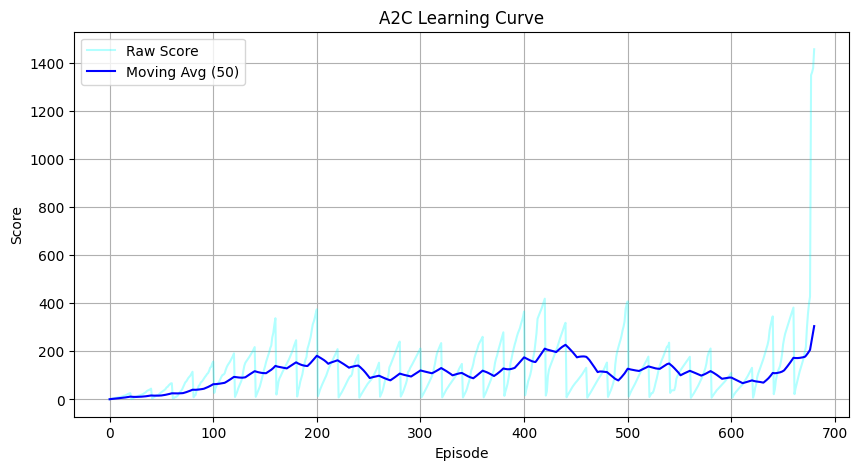

In [5]:
def main():
    env = gym.make('CartPole-v1')
    agent = A2CAgent()
    score = 0.0
    scores = []

    for n_epi in range(10000):
        s, _ = env.reset()
        done = False

        while not done:
            # 행동 선택 (확률 기반)
            s_tensor = torch.from_numpy(s).float().unsqueeze(0)
            pi, _ = agent.model(s_tensor)

            m = Categorical(pi)
            a = m.sample().item()

            s_prime, r, done, truncated, _ = env.step(a)

            agent.train_net(s, a, r/100.0, s_prime, done)

            s = s_prime
            score += r

            if done:
                break

        scores.append(score/20.0)

        if n_epi % 20 == 0 and n_epi != 0:
            print(f"Episode: {n_epi} | Score: {score/20.0:.1f}")

            if score/20.0 >= 500.0:
                print(f"mission complete on Episode {n_epi}! terminate learning.")
                plot_learning_curve(scores)
                break
            score = 0.0
    env.close()

if __name__ == '__main__':
    main()